## Inicializacao

In [2]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))) * 100, 3)
    print('MSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    cc = np.corrcoef(y, yest)
    #print("Correlation pearson:", np.mean(cc))

dataTank = pd.read_csv('data/coupletanks.csv')
u = np.reshape(np.array(dataTank['u']), (1,2401))
y = np.array(dataTank[['tank1', 'tank2']].T)

## Selecao de estrutura

In [3]:
#Selecione o tanque 
output = 0  # 0 ou 1

num = [3, 5]
params = []
params.append({'nb':[2,2],'na':[12], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':8, 'diff':True})
params.append({'nb':[0,2],'na':[1], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':0, 'diff':True})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])

vCandidatos = sselector.matrix_candidate(u, y, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[output, pad:], num[output], 0.00001)
theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)
print(ss)

[Y1.1 U1.12 sqrtM(Y1.1)] [ 1.00029921  0.02485631 -0.04768864]
[1 Y1.1 Y1.2 Y2.1 Y2.2 d(Y1.1) d(Y2.1) U1.9 U1.10 U1.11 U1.12 d(U1.1)
 sqrtM(Y1.1) sqrtM(Y2.1) sqrtM(U1.1)]


[ 1.00029921  0.02485631 -0.04768864] (1, 2401) (2, 2401)


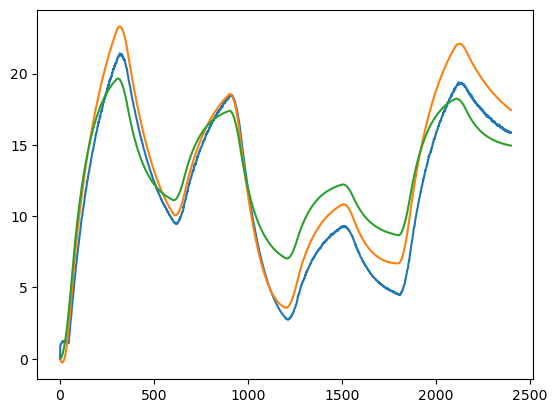

In [4]:
print(theta, u.shape, y.shape)
rr = np.zeros(u.shape)
uu = np.zeros(u.shape)
yy = np.zeros(u.shape)
ww = np.zeros(u.shape)
dh = np.zeros(u.shape)
dy = np.zeros(u.shape)
du = np.zeros(u.shape)

v = np.zeros(u.shape)
w = np.zeros(u.shape)
v[:,0] = u[:,0]
dy[:, 1:] = (y[0, 1:] - y[0, :-1]) / 0.1
du[:, 1:] = (u[0, 1:] - u[0, :-1]) / 0.1
for i in range(1, u.shape[1]):
    rr[:, i] = rr[:, i-1]* theta[0] + (u[:, i] * theta[1] + theta[2] * np.sqrt(y[0, i]))
    dh[:, i] = (u[:, i] * theta[1] + theta[2] * np.sqrt(y[0, i])) / 0.1

    uu[:, i] = uu[:, i-1] + u[:, i] * theta[1]
    yy[:, i] = yy[:, i-1] + np.sqrt(y[0, i]) * theta[2]

    v[:, i] = (np.sqrt(0.1 * np.sum(v[:, :i-1])) * theta[2] + u[:, i] * theta[1]) / 0.1
    #w[:, i] = w[:, i-1] +(du[:, i] - w[:, i-1]) * 0.01#**3 * 0.3
    w[:, i] = w[:, i-1] * 0.99 + (du[:, i]) * 0.0105
    ww[:, i] = ww[:, i-1] + w[:, i] * 0.2


plt.plot(y[0, :].T)
plt.plot(rr.T)
#plt.plot(uu.T + yy.T)
plt.plot(ww.T)
#plt.plot(u.T)
  
'''plt.plot(dy.T)
plt.plot(dh.T)
plt.plot(v.T)'''

'''plt.plot(dy.T)
plt.plot(v.T)
plt.plot(w.T)'''


plt.show()

### Simulação

In [ ]:

slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, diff=True, dt=0.1)

'''index = np.where(y[output,:] != 0)
rs = y[output, index] - slivre[index]
rh = y[output, index] - yhat[index]

print('MAPE LIVRE:', str(round((np.mean(np.abs(rs)/y[output, index])) * 100, 4)) + '%')
print('MAPE OSF:', str(round((np.mean(np.abs(rh)/y[output, index])) * 100, 4)) + '%')

print('MSE LIVRE:', str(round((np.mean(np.abs(rs))), 4)))
print('MSE OSF:', str(round((np.mean(np.abs(rh))), 4)))'''

print("\nSimulação livre")
metrics(y[output], slivre)
print("\nUm passo a frente")
metrics(y[output], yhat)

plt.figure(figsize=(15,4))
plt.title("Tanque " + str(output+1))
plt.plot(y[output].T, label='Original')
plt.plot(yhat, label='um passo a frente')
plt.plot(slivre, label='Livre')
plt.legend()
plt.show()

In [ ]:
r1 = y[output].T - yhat
r2 = y[output].T - slivre
print(np.mean(np.abs(r1)), np.mean(np.abs(r2)))
plt.title('Residuo')
plt.plot(r1, label='um passo a frente')
plt.plot(r2, label='Livre')
plt.legend()
plt.show()

## Validação

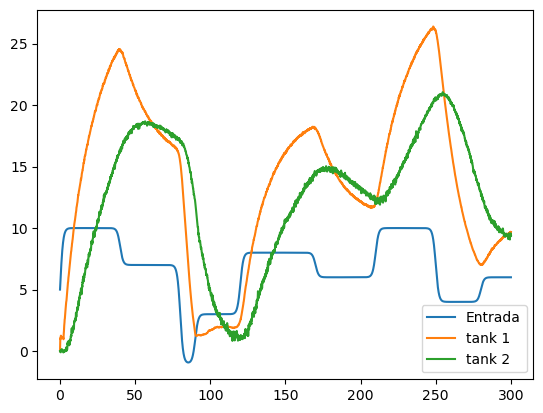

In [6]:
mat_content1 = sc.loadmat("data/ct1x1.mat")
mat_content2 = sc.loadmat("data/ct1x2.mat")

tanque1 = mat_content1['Tanque1']
tanque2 = mat_content2['Tanque2']

t1 = tanque1['time'][0][0]
v1 = tanque1['signals'][0][0]['values'][0][0]

t2 = tanque2['time'][0][0]
v2 = tanque2['signals'][0][0]['values'][0][0]

input = pd.read_csv('data/xinput.csv')
t = input['t']
uVal = np.array(input['v']).reshape((1,-1))

plt.plot(t, uVal.T, label='Entrada')
plt.plot(t1, v1, label="tank 1")
plt.plot(t2, v2, label="tank 2")
plt.legend()
plt.show()

(2, 3001)
Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10, U1.11, U1.12]
Modelo selecionado:
0.0248563094786752⋅U1.12 + 1.00029920714266⋅Y1.1 - 0.0476886357675568⋅sqrtM(Y1
.1)


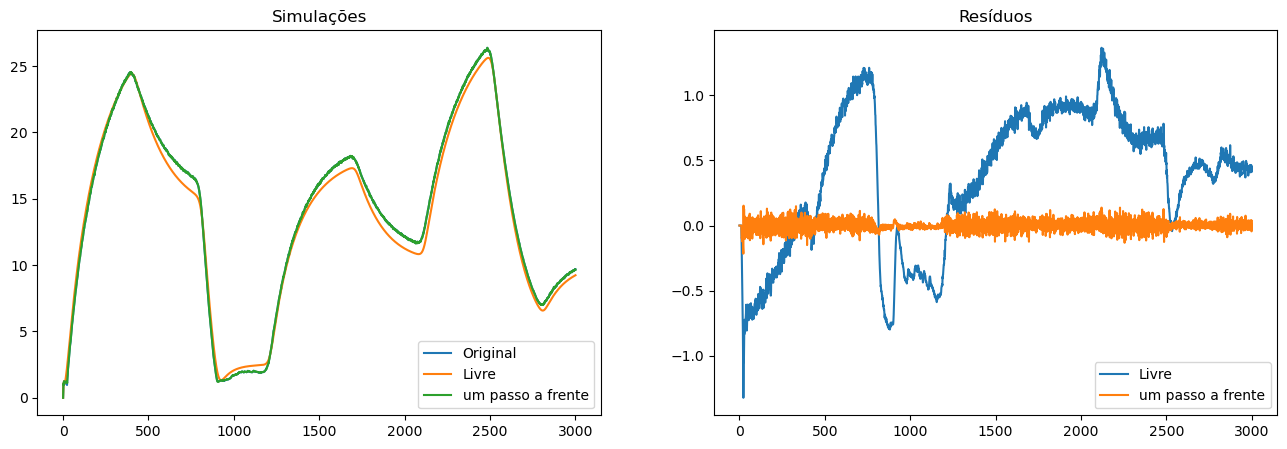

In [8]:
v1[v1 < 0] = 0
v2[v2 < 0] = 0
v2[:100] = 0
yVal = np.vstack((v1.T, v2.T))
print(yVal.shape)
z = np.zeros(yVal.shape)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(1,2, figsize=[16,5])

ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(valLivre, label='Livre')
ax[0].plot(yhat, label='um passo a frente')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - valLivre, label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

In [ ]:
print("\nSimulação livre")
metrics(yVal[output], valLivre)
print("\nUm passo a frente")
metrics(yVal[output], yhat)

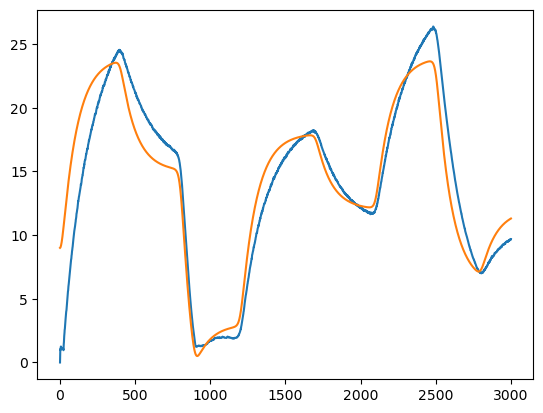

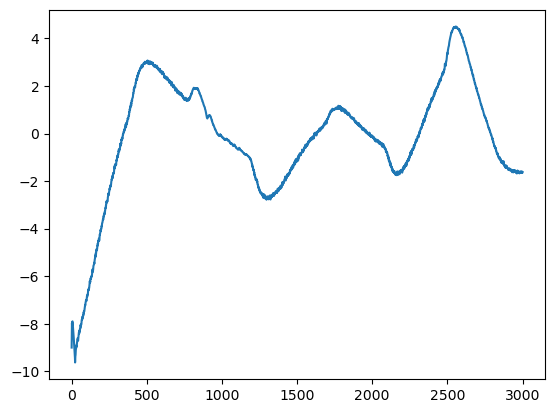

In [25]:
ww = np.zeros(uVal.shape)
dy = np.zeros(uVal.shape)
du = np.zeros(uVal.shape)

w = np.zeros(uVal.shape)
dy[:, 1:] = (yVal[0, 1:] - yVal[0, :-1]) / 0.1
du[:, 1:] = (uVal[0, 1:] - uVal[0, :-1]) / 0.1


for i in range(1, uVal.shape[1]):
    w[:, i] = w[:, i-1] * 0.99 + (du[:, i]) * 0.015
    ww[:, i] = ww[:, i-1] + w[:, i] * 0.2


plt.plot(yVal[0, :].T)
plt.plot(ww.T + 9)
plt.show()
plt.plot((yVal[0, :] - (ww + 9)).T)
plt.show()

In [ ]:
t = t1[:100]

dt = t[1]-t[0]
h = np.cos(t)
dh = -np.sin(t)
ddh = -np.cos(t)

dy = np.zeros(dh.shape)
ddy = np.zeros(dh.shape)

dy[1:] = (h[1:]-h[:-1])/dt
ddy[2:] = (h[2:] - 2 * h[1:-1] +  h[:-2])/(dt**2) # y[t] - 2*y[t-1] + y[t-2]
#print(ddy)

plt.plot(t, h, label='y')
plt.plot(t, dh, label='derivada')
plt.plot(t, ddh, label='2º derivada')
plt.plot(t, dy, label='aproximação derivada')
plt.plot(t, ddy, label='aproximação da 2º derivada')
plt.legend()
plt.show()

In [ ]:
uu = np.zeros(u.shape)
ry = np.zeros(u.shape)
for i in range(1, u.shape[1]):
    uu[:, i] = uu[:, i-1] + u[:, i] * 0.02 * 0.1
    ry[:, i] = np.sqrt(- 0.002085 * uu[:, i]**2 + 0.3206 * uu[:, i] + 0.251306)
